In [1]:
import torch
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

# 加载模型和 tokenizer
def load_model_and_tokenizer(model_name, device="cuda"):
    print(f"Loading model: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        # torch_dtype=torch.float16,
        device_map="auto",
        # attn_implementation="eager",
    )
    return model, tokenizer

In [3]:
# model_name = "mistralai/Mistral-7B-Instruct-v0.1"
model_name = "Qwen/Qwen2-0.5B-Instruct"
device = "cuda" if torch.cuda.is_available() else "mps"

# 加载模型和 tokenizer
model, tokenizer = load_model_and_tokenizer(model_name, device)

# model.config.sliding_window = 1024

Loading model: Qwen/Qwen2-0.5B-Instruct


In [10]:
# 加载和分词输入
dataset = load_dataset("emozilla/pg19", split="test", trust_remote_code=True)
text = dataset[0]["text"]  # 仅取前 16384 个字符
input_ids = tokenizer(text, return_tensors="pt", max_length=16, truncation=True).input_ids

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

In [73]:
input_ids = input_ids[:, 1:]

In [74]:
print(input_ids)

tensor([[   13, 12878,  1094, 12210,  1406,    36,  9345, 10030,   553, 15115,
           482, 15681,   337, 52369,   323,   279,  5787, 51586,  8105,   198,
            35, 25146, 36991,  6154,  7909,  1022,   787, 16413, 27629, 42653,
          3008,   393,  1271,    36,   640, 82831,  1964,  3928,    13, 12878,
          1094,   271,    32, 11101,   315, 28361, 33891,   369,   323, 29014,
           304,   279, 13385,   198,    47, 55398,  8445,   382,  1359, 16654,
         16012, 11418,  5881, 34583, 20594,  4592, 57567, 12152,  2941,    38,
         14017,  3008,   393,  1271,    36,   640, 82831,   382,    32,   425,
          4305, 14884,   451,  3915,  3495,  3008, 28167,    50,  3567, 58619,
         63022,  1479,  4769,  3168, 90296,  8932,   198,    35, 22063,  3008,
          3928,    13, 12878,  1094,    11,   422, 73049, 16165,  4592,  2537,
          4321,  4192,  2679,  7801,   386,    13,  7684, 92923,  1410, 64778,
           279,  9393,   323,  1281,   264,  7216,  

In [11]:
# 提取注意力分数
# 模型前向
with torch.no_grad():
    output = model(input_ids.to(device), output_attentions=True, output_hidden_states=True)

In [7]:
print(output.keys())

odict_keys(['logits', 'past_key_values', 'attentions'])


In [8]:
print(len(output["attentions"]))

24


In [51]:
output["attentions"][0].shape

torch.Size([1, 14, 128, 128])

In [14]:
def visualize_attention_scores(
    attention_scores,
    layer_idx,
    head_idx,
    seq_len,
    output_file=None,
    norm_type="log",  # 标准化类型：可选 "log" 或 "minmax"
    cmap="plasma",    # 颜色映射：默认使用更高对比度的 plasma
    annotate=False    # 是否显示矩阵上的数值
):
    """
    可视化 Transformer 注意力分数矩阵。
    """
    plt.figure(figsize=(5, 4))
    attention_matrix = attention_scores[layer_idx][0, head_idx, :seq_len, :seq_len].cpu()

    # 标准化注意力分数
    if norm_type == "log":
        epsilon = 1e-9
        attention_matrix = torch.log(attention_matrix + epsilon).numpy()
    elif norm_type == "minmax":
        attention_matrix = attention_matrix.numpy()
        attention_matrix = (attention_matrix - attention_matrix.min()) / (
            attention_matrix.max() - attention_matrix.min() + 1e-9
        )

    # 绘制矩阵
    im = plt.imshow(attention_matrix, cmap=cmap, aspect="auto")
    plt.colorbar(im, label="Normalized Attention Score")
    plt.title(f"Attention Layer {layer_idx + 1}, Head {head_idx + 1}")
    plt.xlabel("Key Position")
    plt.ylabel("Query Position")

    # 可选：添加数值标注
    if annotate:
        for i in range(seq_len):
            for j in range(seq_len):
                plt.text(j, i, f"{attention_matrix[i, j]:.2f}", ha="center", va="center", fontsize=6)

    # 保存图像或显示
    if output_file:
        plt.savefig(output_file, dpi=300)
    plt.show()


# # 可视化某一层的注意力分数
# def visualize_attention_scores(attention_scores, layer_idx, head_idx, seq_len, output_file=None):
#     plt.figure(figsize=(10, 8))
#     attention_matrix = attention_scores[layer_idx][0, head_idx, :seq_len, :seq_len].cpu()
#     plt.imshow(attention_matrix, cmap="viridis", aspect="auto")
#     plt.colorbar(label="Attention Score")
#     plt.title(f"Attention Layer {layer_idx + 1}, Head {head_idx + 1}")
#     plt.xlabel("Key Position")
#     plt.ylabel("Query Position")
#     if output_file:
#         plt.savefig(output_file)
#     plt.show()


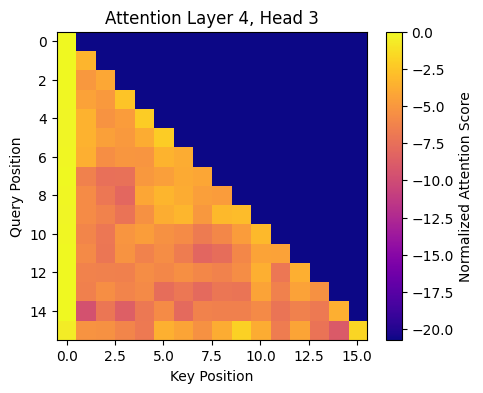

In [16]:

attention_scores = output["attentions"]

# 保存或可视化
layer_idx = 3  # 可视化第几层
head_idx = 2   # 可视化第几个注意力头
seq_len = 8192  # 只显示前 1024 长度的分数（避免图太大）
visualize_attention_scores(attention_scores, layer_idx, head_idx, seq_len, output_file="attention_layer_1_head_1.png")

# # 保存完整注意力分数到文件
# torch.save(attention_scores, "attention_scores.pt")
# print("Attention scores saved to 'attention_scores.pt'")

In [19]:
print(output["attentions"][0].shape)

torch.Size([1, 32, 2110, 2110])


In [17]:
# 计算hidden_states特定token的方差

layer_idx = 3  # 可视化第几层
head_idx = 2   # 可视化第几个注意力头

# 提取特定 token 的隐藏状态
hidden_states = output["hidden_states"][layer_idx]

# 计算每个token各自的方差 保存为一个list
for i in range(hidden_states.shape[1]):
    variance = torch.var(hidden_states[:, i, :])
    print(variance)

tensor(516.3491, device='mps:0')
tensor(0.1098, device='mps:0')
tensor(0.0991, device='mps:0')
tensor(0.1011, device='mps:0')
tensor(0.0806, device='mps:0')
tensor(0.0646, device='mps:0')
tensor(0.0643, device='mps:0')
tensor(0.1013, device='mps:0')
tensor(0.1076, device='mps:0')
tensor(0.0875, device='mps:0')
tensor(0.1048, device='mps:0')
tensor(0.1084, device='mps:0')
tensor(0.0780, device='mps:0')
tensor(0.0865, device='mps:0')
tensor(0.0810, device='mps:0')
tensor(0.0736, device='mps:0')


SyntaxError: invalid syntax (3378313454.py, line 1)

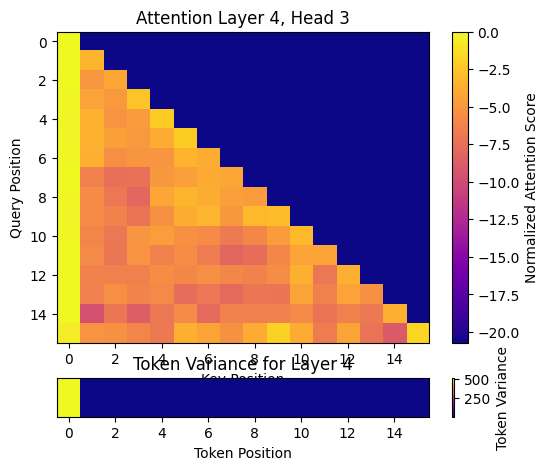

In [31]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_attention_and_variance(
    attention_scores,
    hidden_states,
    layer_idx,
    head_idx,
    seq_len,
    output_file=None,
    norm_type="log",  # 标准化类型：可选 "log" 或 "minmax"
    cmap="plasma",    # 颜色映射：默认使用更高对比度的 plasma
    annotate=False     # 是否显示矩阵上的数值
):
    """
    可视化 Transformer 注意力分数和每个 token 内部值的方差。
    """
    # 创建上下两个子图
    fig, axes = plt.subplots(2, 1, figsize=(6, 5), gridspec_kw={"height_ratios": [4, 0.5]})

    # 获取注意力分数矩阵
    attention_matrix = attention_scores[layer_idx][0, head_idx, :seq_len, :seq_len].cpu()

    # 标准化注意力分数
    if norm_type == "log":
        epsilon = 1e-9
        attention_matrix = torch.log(attention_matrix + epsilon).numpy()
    elif norm_type == "minmax":
        attention_matrix = attention_matrix.numpy()
        attention_matrix = (attention_matrix - attention_matrix.min()) / (
            attention_matrix.max() - attention_matrix.min() + 1e-9
        )

    # 绘制注意力分数热力图
    ax1 = axes[0]
    im1 = ax1.imshow(attention_matrix, cmap=cmap, aspect="auto")
    fig.colorbar(im1, ax=ax1, label="Normalized Attention Score")
    ax1.set_title(f"Attention Layer {layer_idx + 1}, Head {head_idx + 1}")
    ax1.set_xlabel("Key Position")
    ax1.set_ylabel("Query Position")

    # 可选：添加数值标注
    if annotate:
        for i in range(seq_len):
            for j in range(seq_len):
                ax1.text(j, i, f"{attention_matrix[i, j]:.2f}", ha="center", va="center", fontsize=6)

    # 计算每个 token 的方差
    token_variances = torch.var(hidden_states[layer_idx][:, :seq_len, :], dim=-1).squeeze(0).cpu().numpy()

    # 转为二维矩阵（单行）
    token_variances = np.expand_dims(token_variances, axis=0)  # 转为 1xN 矩阵以适配热力图

    # 绘制方差热力图
    ax2 = axes[1]
    im2 = ax2.imshow(token_variances, cmap="plasma", aspect="auto")
    fig.colorbar(im2, ax=ax2, label="Token Variance")
    ax2.set_title(f"Token Variance for Layer {layer_idx + 1}")
    ax2.set_xlabel("Token Position")
    ax2.set_yticks([])  # 隐藏 y 轴刻度

    # 保存图像或显示
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.show()

# 示例调用
# 请将 `attention_scores` 和 `hidden_states` 替换为实际数据
visualize_attention_and_variance(output["attentions"], output["hidden_states"], layer_idx=3, head_idx=2, seq_len=50)


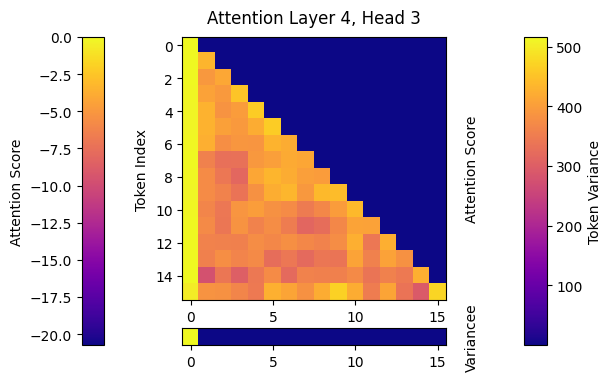

In [161]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_attention_and_variance(
    attention_scores,
    hidden_states,
    layer_idx,
    head_idx,
    seq_len,
    output_file=None,
    norm_type="log",  # 标准化类型：可选 "log" 或 "minmax"
    cmap="plasma",    # 颜色映射：默认使用更高对比度的 plasma
    annotate=False    # 是否显示矩阵上的数值
):
    """
    将布局改为：
    ┌─────────┬─────────────────┬─────────┐
    │         │   上:热力图     │         │
    │  左CB   ├─────────────────┤  右CB   │
    │         │   下:热力图     │         │
    └─────────┴─────────────────┴─────────┘
    其中 1×3 网格：左列放注意力热力图的colorbar，中间列是上下热力图(再细分为2×1)，右列放方差热力图的colorbar
    """

    # 1. 创建主图与 1×3 主网格
    fig = plt.figure(figsize=(6, 4))
    gs_main = fig.add_gridspec(nrows=1, ncols=3, width_ratios=[0.2, 3, 0.2], wspace=0.3)

    # 2. 中间列做成 2 行 1 列的子网格，用于放置上下两个热力图
    gs_center = gs_main[0, 1].subgridspec(nrows=2, ncols=1, height_ratios=[16, 1], hspace=0.2)

    # 分别创建上、下两个 Axes
    ax_top = fig.add_subplot(gs_center[0, 0])    # 上
    ax_bottom = fig.add_subplot(gs_center[1, 0]) # 下

    # 左侧 colorbar Axes (给“上方注意力”用)
    cax_left = fig.add_subplot(gs_main[0, 0])
    # 右侧 colorbar Axes (给“下方方差”用)
    cax_right = fig.add_subplot(gs_main[0, 2])

    # 3. 处理注意力矩阵
    attention_matrix = attention_scores[layer_idx][0, head_idx, :seq_len, :seq_len].cpu()
    if norm_type == "log":
        epsilon = 1e-9
        attention_matrix = torch.log(attention_matrix + epsilon).numpy()
    elif norm_type == "minmax":
        attention_matrix = attention_matrix.numpy()
        attention_matrix = (attention_matrix - attention_matrix.min()) / (
            attention_matrix.max() - attention_matrix.min() + 1e-9
        )
    else:
        attention_matrix = attention_matrix.numpy()

    # 4. 绘制“上方”的注意力热力图
    im1 = ax_top.imshow(attention_matrix, cmap=cmap, aspect="equal", interpolation="nearest")
    ax_top.set_box_aspect(1)
    ax_top.set_title(f"Attention Layer {layer_idx + 1}, Head {head_idx + 1}", pad=10)
    ax_top.set_xlabel("Token Index")
    ax_top.set_ylabel("Token Index")
    # 在右边添加额外的标签
    ax_top.text(1.1, 0.5, "Attention Score", transform=ax_top.transAxes, rotation=90, va="center", ha="center")

    # 可选：矩阵数值标注
    if annotate:
        for i in range(seq_len):
            for j in range(seq_len):
                ax_top.text(j, i, f"{attention_matrix[i, j]:.2f}",
                            ha="center", va="center", fontsize=6)

    # 给“上方热力图”创建 colorbar，放在左侧 cax_left
    cb1 = fig.colorbar(im1, cax=cax_left, orientation='vertical')
    cb1.set_label("Attention Score")
    cb1.ax.yaxis.set_ticks_position('left')
    cb1.ax.yaxis.set_label_position('left')

    # 5. 计算并绘制“下方”的方差热力图（单行）
    token_variances = torch.var(hidden_states[layer_idx][:, :seq_len, :], dim=-1).squeeze(0).cpu().numpy()
    token_variances = np.expand_dims(token_variances, axis=0)  # 转为 1×N

    im2 = ax_bottom.imshow(token_variances, cmap=cmap, aspect="equal", interpolation="nearest")
    # ax_bottom.set_title(f"Token Variance for Layer {layer_idx + 1}", y=-1.5)
    # ax_bottom.set_ylabel("Variance", y=0.5, x=1.05)
    ax_bottom.text(1.1, 0.5, "Variancee", transform=ax_bottom.transAxes, rotation=90, va="center", ha="center")
    ax_bottom.yaxis.set_label_position('right')
    ax_bottom.set_box_aspect(1/16)
    ax_bottom.set_yticks([])  # 隐藏 y 轴

    # 给“下方热力图”创建 colorbar，放在右侧 cax_right
    cb2 = fig.colorbar(im2, cax=cax_right, orientation='vertical')
    cb2.set_label("Token Variance")

    # 6. 保存或者显示
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.show()

visualize_attention_and_variance(output["attentions"], output["hidden_states"], layer_idx=3, head_idx=2, seq_len=50)

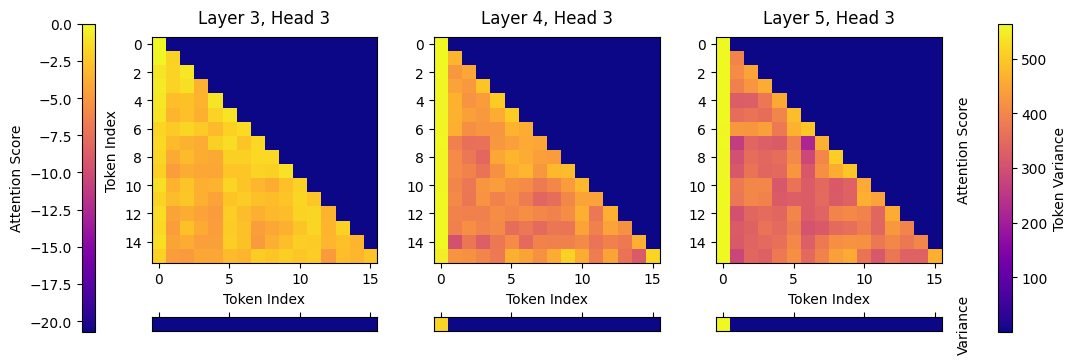

In [200]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_multi_layers_single_row(
    attention_scores,
    hidden_states,
    layers,              # list/iterable of layer indices to plot
    head_idx,            # 如果你只想看同一个 head，可固定 head_idx
    seq_len,
    output_file=None,
    norm_type="log",     # "log", "minmax", 或 None
    cmap="plasma",
    annotate=False
):
    """
    在“只有一行”的布局下，横向排多个 Layer，每个 Layer 里再上下叠放:
      - 上: 注意力 (seq_len×seq_len)
      - 下: 方差   (1×seq_len)
    左右两侧各只放一个 colorbar：左边给所有注意力图，右边给所有方差图。

    最外层 1×(num_layers + 2) 网格结构:
    ┌──────────┬────────────────┬────────────────┬ ... ┬─────────────────┬───────────┐
    │ 左CB(col=0) │ Layer1(subgrid) │ Layer2(subgrid) │ ... │ LayerN(subgrid) │ 右CB(col=N+1)│
    └──────────┴────────────────┴────────────────┴-----┴─────────────────┴───────────┘

    其中每个 layer 的 subgrid 再是 2×1:
      - row=0: 注意力热力图(上)
      - row=1: 方差热力图(下)
    """

    num_layers = len(layers)

    #========== 1. 预先收集所有矩阵、计算全局 min/max ==========#
    all_attention_mats = []
    all_variance_mats  = []
    for layer_idx in layers:
        # ---- 注意力矩阵 ----
        attn_mat = attention_scores[layer_idx][0, head_idx, :seq_len, :seq_len].cpu()
        if norm_type == "log":
            epsilon = 1e-9
            attn_mat = torch.log(attn_mat + epsilon)
        elif norm_type == "minmax":
            attn_mat = (attn_mat - attn_mat.min()) / (attn_mat.max() - attn_mat.min() + 1e-9)
        attn_mat = attn_mat.numpy()
        all_attention_mats.append(attn_mat)

        # ---- 方差矩阵(1×seq_len) ----
        var_mat = torch.var(hidden_states[layer_idx][:, :seq_len, :], dim=-1).squeeze(0).cpu().numpy()
        var_mat = np.expand_dims(var_mat, axis=0)  # 变成 (1, seq_len)
        all_variance_mats.append(var_mat)

    # (可选) 全局 min/max, 用于共享色表
    attn_min = min(m.min() for m in all_attention_mats)
    attn_max = max(m.max() for m in all_attention_mats)
    var_min  = min(m.min() for m in all_variance_mats)
    var_max  = max(m.max() for m in all_variance_mats)

    attn_norm = mpl.colors.Normalize(vmin=attn_min, vmax=attn_max)
    var_norm  = mpl.colors.Normalize(vmin=var_min, vmax=var_max)

    #========== 2. 创建最外层 figure & gridspec (1 行 + num_layers+2 列) ==========#
    fig = plt.figure(figsize=(3 + 3*num_layers, 4))
    gs_main = fig.add_gridspec(
        nrows=1, ncols=num_layers+2,
        width_ratios=[0.3] + [5]*num_layers + [0.3],  # 左 colorbar(0.2), 中间每层(3), 右 colorbar(0.2)
        wspace=0.4
    )

    # 左、右 colorbar Axes
    cax_left  = fig.add_subplot(gs_main[0, 0])
    cax_right = fig.add_subplot(gs_main[0, num_layers+1])

    #========== 3. 遍历每个 layer，在中间相应的列创建 2×1 subgridspec ==========#
    for i, layer_idx in enumerate(layers):
        # 这个列在 top-level gridspec 中是 col = i + 1
        subgrid = gs_main[0, i+1].subgridspec(nrows=2, ncols=1, height_ratios=[16, 1], hspace=0.3)

        # -- 上: 注意力热力图 --
        ax_top = fig.add_subplot(subgrid[0, 0])
        attn_mat = all_attention_mats[i]
        im_top = ax_top.imshow(
            attn_mat,
            cmap=cmap,
            norm=attn_norm,
            aspect="equal",
            interpolation="nearest"
        )
        # 标题
        ax_top.set_title(f"Layer {layer_idx+1}, Head {head_idx+1}", pad=10)

        ax_top.set_xlabel("Token Index")
        # 如果是第一个 layer，添加 x 轴标签
        if i == 0:
            ax_top.set_ylabel("Token Index")
        # 保证上图是 NxN 正方形
        ax_top.set_box_aspect(1)

        # 是否在热力图内显示数值
        if annotate:
            s_len = attn_mat.shape[0]
            for r in range(s_len):
                for c in range(s_len):
                    ax_top.text(c, r, f"{attn_mat[r,c]:.2f}",
                                ha="center", va="center", fontsize=6)

        # -- 下: 方差热力图(1×seq_len) --
        ax_bottom = fig.add_subplot(subgrid[1, 0])
        var_mat = all_variance_mats[i]
        im_bottom = ax_bottom.imshow(
            var_mat,
            cmap=cmap,
            norm=var_norm,
            aspect="equal",
            interpolation="nearest"
        )
        # ax_bottom.set_xlabel("Token")
        ax_bottom.tick_params(axis='x', which='both', labelbottom=False)
        ax_bottom.xaxis.tick_top()
        ax_bottom.set_yticks([])  # 隐藏 y 轴
        # 下图只有 1 行 vs. seq_len 列，如果想让每个格子跟上面一样大，需要适度控制纵横比
        # 这里 height_ratios=[16,1] 已经让下方更扁，同时 aspect="equal" 让其看起来为小方格
        # 也可再对 set_box_aspect() 做精调:
        #   ax_bottom.set_box_aspect(1/16)  # 视 seq_len 的大小而定
        ax_bottom.set_box_aspect(1/16)

        # 如果是最后一个 layer，添加右侧 text
        if i == num_layers - 1:
            ax_top.text(1.1, 0.5, "Attention Score", transform=ax_top.transAxes, rotation=90, va="center", ha="center")
            ax_bottom.text(1.1, 0.5, "Variance", transform=ax_bottom.transAxes, rotation=90, va="center", ha="center")

    #========== 4. 整体只放两个 colorbar：左(注意力)、右(方差) ==========#
    # 注意力 colorbar
    sm_attn = mpl.cm.ScalarMappable(norm=attn_norm, cmap=cmap)
    cb1 = fig.colorbar(sm_attn, cax=cax_left, orientation='vertical')
    cb1.ax.yaxis.set_ticks_position('left')
    cb1.ax.yaxis.set_label_position('left')
    cb1.set_label("Attention Score")

    # 方差 colorbar
    sm_var = mpl.cm.ScalarMappable(norm=var_norm, cmap=cmap)
    cb2 = fig.colorbar(sm_var, cax=cax_right, orientation='vertical')
    cb2.set_label("Token Variance")

    #========== 5. 保存或显示 ==========#
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.show()

layers_to_plot = [2, 3, 4]
visualize_multi_layers_single_row(
    attention_scores=output["attentions"],
    hidden_states=output["hidden_states"],
    layers=layers_to_plot,
    head_idx=2,
    seq_len=50,
    norm_type="log",    # 可选: "log", "minmax", 或 None
    cmap="plasma",
    annotate=False
)
